In [1]:
import glob
import os
from typing import Union
import warnings

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import MDAnalysis as mda
import numpy as np
from openmm import app
import pandas as pd
import pint
from scipy import optimize
from scipy.signal import argrelextrema
from scipy.special import erf
import seaborn as sns

from mdcraft import ureg
from mdcraft.algorithm.topology import create_atoms
from mdcraft.algorithm.unit import get_lj_scale_factors
from mdcraft.algorithm.utility import rebin
from mdcraft.analysis import profile, structure
from mdcraft.fit.polynomial import poly1, poly2
from mdcraft.plot.axis import set_up_tabular_legend
from mdcraft.plot import rcparam

rcparam.update("acs", font_scaling=4/3, size_scaling=1.5,
               **{"lines.linewidth": 2, "legend.handlelength": 1.5})
pint.set_application_registry(ureg)
warnings.filterwarnings("ignore")

root = "/mnt/e/research/gcme/methodology"
cmap = sns.color_palette("deep")
dpi = 1_200

/home/bye/miniconda3/envs/research/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Ewald summation

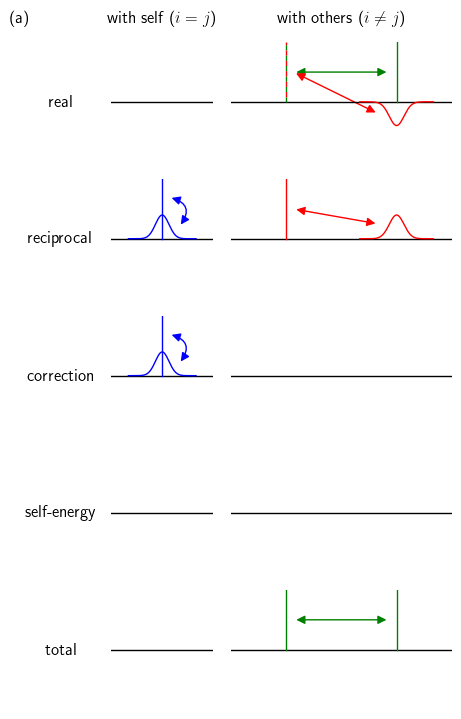

In [2]:
def gauss(x: Union[float, np.ndarray[float]], mu: float, sigma: float):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def arrow(
        start: tuple[float], stop: tuple[float], head_length: float = None,
        head_width: float = None, color: str = None, radius: float = None):

    kw = {"arrowstyle": f"<|-|>,{head_length=},{head_width=}", "color": color}
    if radius:
        kw["connectionstyle"] = f"arc3,rad={radius}"
    return patches.FancyArrowPatch(start, stop, **kw)

r = np.linspace(-5, 5, 1_000)
r_shift = r + 15
charge = gauss(r, 0, 0.5)
screen = -gauss(r, 0, 1)

fig = plt.figure(figsize=(4.875, 7.3125))
gs = fig.add_gridspec(5, 3)
axs = np.asarray(
    [(fig.add_subplot(gs[i, 0]),
      fig.add_subplot(gs[i, 1:])) for i in range(5)]
)
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axhline(0, c="k", lw=1)
        ax.set_xlim((-7.5, 7.5 + j * 15))
        ax.set_ylim((-1, 1))
        ax.set_axis_off()

axs[0, 0].text(-1, 1.209, "(a)", va="center", transform=axs[0, 0].transAxes)
for i, row in enumerate(("real", "reciprocal", "correction", "self-energy", "total")):
    axs[i, 0].text(-0.5, 0.5, row, ha="center", va="center", transform=axs[i, 0].transAxes)
for j, col in enumerate(("with self ($i=j$)", r"with others ($i\neq j$)")):
    axs[0, j].text(0.5, 1.209, col, ha="center", va="center", transform=axs[0, j].transAxes)

axs[0, 1].plot((0, 0), (0, 1), "g", ls=(0, (3.75, 3.75)), lw=1)
axs[0, 1].plot((15, 15), (0, 1), "g", lw=1)
axs[0, 1].add_patch(arrow((1, 0.5), (14, 0.5), 5, 2.5, color="g"))
axs[0, 1].plot((0, 0), (0, 1), "r", ls=(3.75, (3.75, 3.75)), lw=1)
axs[0, 1].plot(r_shift, screen, "r", lw=1)
axs[0, 1].add_patch(arrow((1, 0.5), (12.5, -0.2), 5, 2.5, color="r"))

axs[1, 0].plot((0, 0), (0, 1), "b", lw=1)
axs[1, 0].plot(r, -screen, "b", lw=1)
axs[1, 0].add_patch(arrow((2.5, 0.2), (1, 0.7), 5, 2.5, color="b", radius=0.75))
axs[1, 1].plot((0, 0), (0, 1), "r", lw=1)
axs[1, 1].plot(r_shift, -screen, "r", lw=1)
axs[1, 1].add_patch(arrow((1, 0.5), (12.5, 0.25), 5, 2.5, color="r"))

axs[2, 0].plot((0, 0), (0, 1), "b", lw=1)
axs[2, 0].plot(r, -screen, "b", lw=1)
axs[2, 0].add_patch(arrow((2.5, 0.2), (1, 0.7), 5, 2.5, color="b", radius=0.75))

axs[4, 1].plot((0, 0), (0, 1), "g", lw=1)
axs[4, 1].plot((15, 15), (0, 1), "g", lw=1)
axs[4, 1].add_patch(arrow((1, 0.5), (14, 0.5), 5, 2.5, color="g"))

if not os.path.isfile(f"{root}/figures/ewald_coul.eps"):
    plt.savefig(f"{root}/figures/ewald_coul.eps", dpi=dpi)
plt.show()

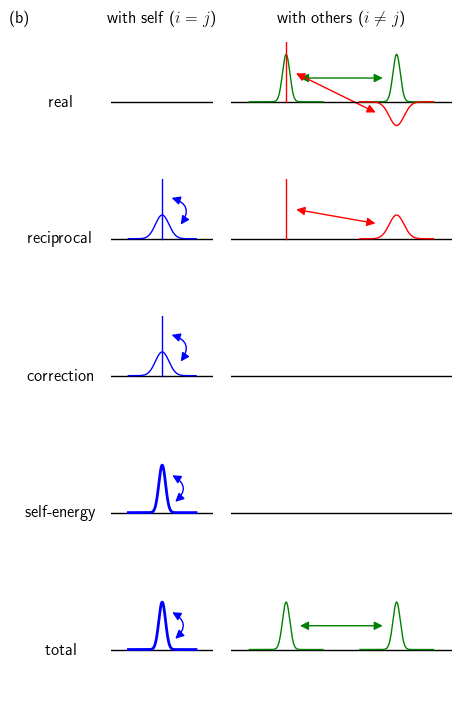

In [3]:
fig = plt.figure(figsize=(4.875, 7.3125))
gs = fig.add_gridspec(5, 3)
axs = np.asarray(
    [(fig.add_subplot(gs[i, 0]),
      fig.add_subplot(gs[i, 1:])) for i in range(5)]
)
for i, row in enumerate(axs):
    for j, ax in enumerate(row):
        ax.axhline(0, c="k", lw=1)
        ax.set_xlim((-7.5, 7.5 + j * 15))
        ax.set_ylim((-1, 1))
        ax.set_axis_off()

axs[0, 0].text(-1, 1.209, "(b)", va="center", transform=axs[0, 0].transAxes)
for i, row in enumerate(("real", "reciprocal", "correction", "self-energy", "total")):
    axs[i, 0].text(-0.5, 0.5, row, ha="center", va="center", transform=axs[i, 0].transAxes)
for j, col in enumerate(("with self ($i=j$)", r"with others ($i\neq j$)")):
    axs[0, j].text(0.5, 1.209, col, ha="center", va="center", transform=axs[0, j].transAxes)

axs[0, 1].plot(r, charge, "g", lw=1)
axs[0, 1].plot(r_shift, charge, "g", lw=1)
axs[0, 1].add_patch(arrow((1.5, 0.4), (13.5, 0.4), 5, 2.5, color="g"))
axs[0, 1].plot((0, 0), (0, 1), "r", lw=1)
axs[0, 1].plot(r_shift, screen, "r", lw=1)
axs[0, 1].add_patch(arrow((1, 0.5), (12.5, -0.2), 5, 2.5, color="r"))

axs[1, 0].plot((0, 0), (0, 1), "b", lw=1)
axs[1, 0].plot(r, -screen, "b", lw=1)
axs[1, 0].add_patch(arrow((2.5, 0.2), (1, 0.7), 5, 2.5, color="b", radius=0.75))
axs[1, 1].plot((0, 0), (0, 1), "r", lw=1)
axs[1, 1].plot(r_shift, -screen, "r", lw=1)
axs[1, 1].add_patch(arrow((1, 0.5), (12.5, 0.25), 5, 2.5, color="r"))

axs[2, 0].plot((0, 0), (0, 1), "b", lw=1)
axs[2, 0].plot(r, -screen, "b", lw=1)
axs[2, 0].add_patch(arrow((2.5, 0.2), (1, 0.7), 5, 2.5, color="b", radius=0.75))

axs[3, 0].plot(r, charge, "b")
axs[3, 0].add_patch(arrow((1.625, 0.15), (1.125, 0.65), 5, 2.5, color="b", radius=0.75))

axs[4, 0].plot(r, charge, "b")
axs[4, 0].add_patch(arrow((1.625, 0.15), (1.125, 0.65), 5, 2.5, color="b", radius=0.75))
axs[4, 1].plot(r, charge, "g", lw=1)
axs[4, 1].plot(r_shift, charge, "g", lw=1)
axs[4, 1].add_patch(arrow((1.5, 0.4), (13.5, 0.4), 5, 2.5, color="g"))

if not os.path.isfile(f"{root}/figures/ewald_gcme.eps"):
    plt.savefig(f"{root}/figures/ewald_gcme.eps", dpi=dpi)
plt.show()

### Model

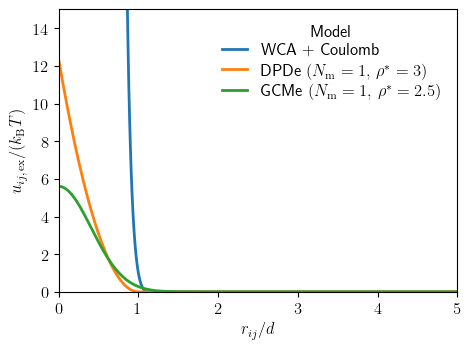

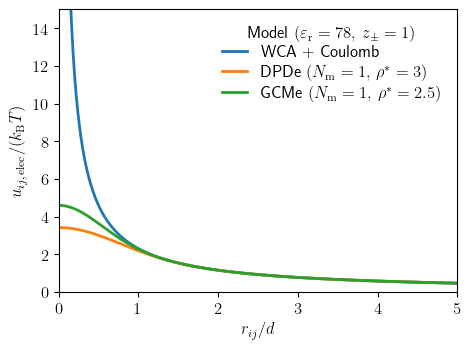

In [4]:
def lj(
        eps: Union[float, pint.Quantity], sigma: Union[float, pint.Quantity],
        r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    R = (sigma / r) ** 6
    return 4 * eps * (R * (R - 1))

def coul(
        dielectric: float, r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    return ureg.elementary_charge ** 2 / (4 * np.pi * ureg.vacuum_permittivity * dielectric * r)

def dpd(
        A: Union[float, pint.Quantity], r_cut: Union[np.ndarray[float], pint.Quantity],
        r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    return A * r_cut * (1 - r / r_cut) ** 2 / 2

def dpde(
        dielectric: float, r_e: Union[float, pint.Quantity],
        r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    u = np.zeros_like(r) / ureg.angstrom
    i = r <= r_e
    u[i] = (52 / 35 - 4 * (r[i] / r_e) ** 2 / 5 + 2 * (r[i] / r_e) ** 4 / 5 - 0.13587 * (r[i] / r_e) ** 5.145) / r_e
    i = (r > r_e) & (r <= 2 * r_e)
    u[i] = (r_e / r[i] - 3.21 * (1 - r[i] / (2 * r_e)) ** 6) / r_e
    i = r > 2 * r_e
    u[i] = 1 / r[i]
    return u * ureg.elementary_charge ** 2 / (4 * np.pi * ureg.vacuum_permittivity * dielectric)

def gcm(A: Union[float, pint.Quantity], sigma: Union[float, pint.Quantity],
        r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    return A * (3 / (2 * np.pi * sigma ** 2)) ** (3 / 2) * np.exp(-3 * r ** 2 / (2 * sigma ** 2))

def gcme(
        dielectric: float, a: Union[np.ndarray[float], pint.Quantity],
        r: Union[np.ndarray[float], pint.Quantity]
    ) -> Union[np.ndarray[float], pint.Quantity]:
    x = np.sqrt(np.pi / 2) * r / a
    if isinstance(x, ureg.Quantity):
        x = x.magnitude
    return coul(dielectric, r) * erf(x)

dielectric = 78
temperature = 300 * ureg.kelvin
sigma = 30 ** (1 / 3) * ureg.angstrom
epsilon = ureg.boltzmann_constant * temperature
r = np.linspace(0, 5 * sigma.magnitude, 5_000) * ureg.nanometer
r_reduced = r / sigma
u_wca = lj(epsilon, sigma, r) - lj(epsilon, sigma, 2 ** (1 / 6) * sigma)
u_wca[r > 2 ** (1 / 6) * sigma] = 0 * ureg.kilojoule
u_coul = coul(dielectric, r)

rho_dpd_reduced = 3
alpha_dpd = 0.101 * sigma ** 4
a_dpd = 14.9835 * epsilon / (2 * alpha_dpd * (rho_dpd_reduced / sigma ** 3))
u_dpd = dpd(a_dpd, sigma, r)
u_dpd[r_reduced > 1] = 0 * ureg.kilojoule
u_dpde = dpde(dielectric, sigma, r)

rho_gcm_reduced = 2.5
A_gcm = 14.9835 * epsilon / (0.998 * (rho_gcm_reduced / sigma ** 3))
u_gcm = gcm(A_gcm, sigma / np.sqrt(2), r)
u_gcme = gcme(dielectric, sigma / np.sqrt(2), r)

_, ax = plt.subplots()
ax.plot(r_reduced, u_wca / epsilon, label="WCA + Coulomb")
ax.plot(r_reduced, u_dpd / epsilon, label=r"DPDe $(N_\mathrm{m}=1,\,\rho^*=3)$")
ax.plot(r_reduced, u_gcm / epsilon, label=r"GCMe $(N_\mathrm{m}=1,\,\rho^*=2.5)$")
ax.legend(title="Model")
ax.set_xlabel("$r_{ij}/d$")
ax.set_xlim((0, 5))
ax.set_ylabel("$u_{ij,\,\mathrm{ex}}/(k_\mathrm{B}T)$")
ax.set_ylim((0, 15))
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
plt.show()

_, ax = plt.subplots()
ax.plot(r_reduced, u_coul / epsilon, label="WCA + Coulomb")
ax.plot(r_reduced, u_dpde / epsilon, label=r"DPDe $(N_\mathrm{m}=1,\,\rho^*=3)$")
ax.plot(r_reduced, u_gcme / epsilon, label=r"GCMe $(N_\mathrm{m}=1,\,\rho^*=2.5)$")
ax.legend(title=r"Model $(\varepsilon_\mathrm{r}=78,\,z_{\pm}=1)$")
ax.set_xlabel("$r_{ij}/d$")
ax.set_xlim((0, 5))
ax.set_ylabel("$u_{ij,\,\mathrm{elec}}/(k_\mathrm{B}T)$")
ax.set_ylim((0, 15))
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
plt.show()

### Table of Contents (ToC Image)

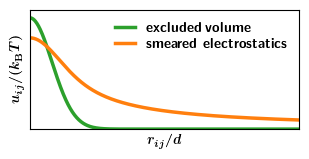

In [5]:
plt.rcParams.update({"text.latex.preamble": r"\usepackage{bm}"})

_, ax = plt.subplots(figsize=(3.25, 1.75))
ax.plot(r_reduced, u_gcm / epsilon, color="C2", lw=2.5, label=r"$\textbf{excluded volume}$")
ax.plot(r_reduced, u_gcme / epsilon, color="C1", lw=2.5, label=r"$\textbf{smeared electrostatics}$")
ax.legend(edgecolor="none", facecolor="none", fontsize=10)
ax.set_xlabel(r"$\bm{r_{ij}/d}$", fontsize=10)
ax.set_xlim((0, 5))
ax.set_xticks([])
ax.set_ylabel(r"$\bm{u_{ij}/(k_\mathrm{B}T)}$", fontsize=10)
ax.set_ylim((0, 6))
ax.set_yticks([])
if not os.path.isfile(f"{root}/figures/toc.png"):
    plt.savefig(f"{root}/figures/toc.png", dpi=600, transparent=True)
plt.show()

### Parametrization

In [6]:
N = 10_000
molar_mass = 18.01528 * ureg.gram / ureg.mole
diameter = 0.275 * ureg.nanometer
temperature = 300 * ureg.kelvin
kappa_inv = 15.9835
scales = get_lj_scale_factors({
    "energy": (ureg.boltzmann_constant * temperature).to(ureg.kilojoule),
    "length": diameter, "mass": molar_mass
})

#### Optimal $A_{ij}$–$\rho$ relationship

In [7]:
start = 1_000
markers = ("o", "^", "s", "D")
marker_sizes = {"o": 5, "^": 6, "s": 5, "D": 4}

In [8]:
os.chdir(f"{root}/data/parametrization/water/npt")

As_ps = [f.rstrip(".log").split("_")[2::2] for f in glob.glob("*.log")]
As_reduced = np.array(sorted({float(A_p[0]) for A_p in As_ps}))
ps_reduced = np.array(sorted({float(A_p[1]) for A_p in As_ps}))

volumes = np.empty((len(As_reduced), len(ps_reduced))) * ureg.nanometer ** 3
for i, A_reduced in enumerate(As_reduced):
    volumes[i] = np.fromiter(
        (pd.read_csv(f"npt_A_{A_reduced:.1f}_p_{p_reduced:.2f}.log")
         ["Box Volume (nm^3)"][start:].mean()
         for p_reduced in ps_reduced),
        dtype=float,
        count=len(ps_reduced)
    ) * ureg.nanometer ** 3
rhos_reduced = (N * scales["length"] ** 3 / volumes).magnitude

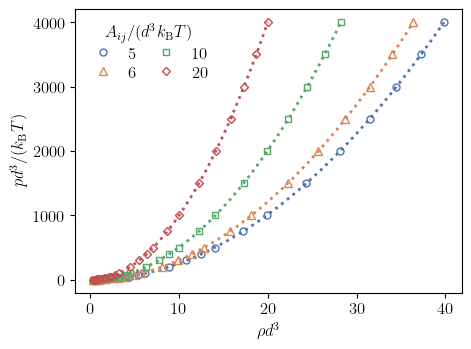

In [9]:
coefs_p_rho = np.empty((len(As_reduced), 2), dtype=float)
rhos_fit_reduced = np.empty((len(As_reduced), 100), dtype=float)

_, ax = plt.subplots()
for i, (A_reduced, m) in enumerate(zip(As_reduced, markers)):
    ax.plot(rhos_reduced[i], ps_reduced, m, mec=cmap[i], mfc="none", ms=marker_sizes[m],
            label=fr"${A_reduced:.2g}$")
    coefs_p_rho[i] = optimize.curve_fit(lambda x, a, b: poly2(x, a, b, 0),
                                        rhos_reduced[i], ps_reduced)[0]
    rhos_fit_reduced[i] = np.linspace(np.min(rhos_reduced[i]),
                                      np.max(rhos_reduced[i]), 100)
    ps_fit_reduced = poly2(rhos_fit_reduced[i], *coefs_p_rho[i], 0)
    ax.plot(rhos_fit_reduced[i], ps_fit_reduced, ":", color=cmap[i])
ax.legend(title="$A_{ij}/(d^3k_\mathrm{B}T)$", ncols=2)
ax.set_xlabel("$\\rho d^3$")
ax.set_ylabel("$pd^3/(k_\mathrm{B}T)$")
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_p_vs_rho.eps"):
    plt.savefig(f"{root}/figures/water_p_vs_rho.eps", dpi=dpi)
plt.show()

A_reduced=5.0, omega=0.498880
A_reduced=6.0, omega=0.498815
A_reduced=10.0, omega=0.498652
A_reduced=20.0, omega=0.498385


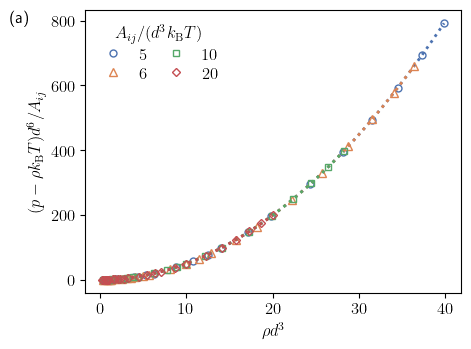

In [10]:
omegas = np.empty((len(As_reduced), 2), dtype=float)
ps_excess_fit_reduced = np.empty_like(rhos_fit_reduced)

_, ax = plt.subplots()
for i, (A_reduced, m) in enumerate(zip(As_reduced, markers)):
    y = (ps_reduced - rhos_reduced[i]) / A_reduced
    ax.plot(rhos_reduced[i], y, m, mec=cmap[i], mfc="none", ms=marker_sizes[m],
            label=f"${A_reduced:.2g}$")
    omegas[i, 0] = optimize.curve_fit(lambda x, omega: poly2(x, omega, 0, 0),
                                      rhos_reduced[i], y)[0]
    print(f"{A_reduced=}, omega={omegas[i, 0]:.6f}")
    ps_excess_fit_reduced[i] = poly2(rhos_fit_reduced[i], omegas[i, 0], 0, 0)
    ax.plot(rhos_fit_reduced[i], ps_excess_fit_reduced[i], ":", color=cmap[i])
ax.legend(title="$A_{ij}/(d^3k_\mathrm{B}T)$", ncols=2)
ax.set_xlabel("$\\rho d^3$")
ax.set_ylabel("$(p-\\rho k_\mathrm{B}T)d^6/A_{ij}$")
ax.text(-0.2, 0.959, "(a)", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_p_excess_vs_rho.eps"):
    plt.savefig(f"{root}/figures/water_p_excess_vs_rho.eps", dpi=dpi)
plt.show()

A_reduced=5.0, omega=0.499151
A_reduced=6.0, omega=0.499081
A_reduced=10.0, omega=0.498990
A_reduced=20.0, omega=0.498812


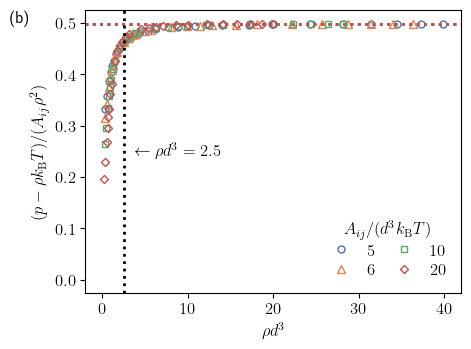

In [11]:
_, ax = plt.subplots()
xlim = (-2, 42)
ylim = (-0.025, 0.525)
for i, (A_reduced, m) in enumerate(zip(As_reduced, markers)):
    y = (ps_reduced - rhos_reduced[i]) / (A_reduced * rhos_reduced[i] ** 2)
    ax.plot(rhos_reduced[i], y, m, mec=cmap[i], mfc="none", ms=marker_sizes[m],
            label=f"${A_reduced:.3g}$")
    omegas[i, 1] = y[-1]
    print(f"{A_reduced=}, omega={omegas[i, 1]:.6f}")
    y_fit = ps_excess_fit_reduced[i, :2] / rhos_fit_reduced[i, :2] ** 2
    ax.plot(xlim, y_fit, ":", color=cmap[i])
ax.plot((2.5, 2.5), ylim, "k:")
ax.text(3.75, 0.25, r"$\leftarrow\rho d^3=2.5$", va="center")
ax.legend(title=r"$A_{ij} / ( d^3 k_\mathrm{B} T)$", ncols=2)
ax.set_xlabel(r"$\rho d^3$")
ax.set_xlim(xlim)
ax.set_ylabel(r"$ (p - \rho k_\mathrm{B} T) / (A_{ij} \rho^2)$")
ax.set_ylim(ylim)
ax.text(-0.2, 0.959, "(b)", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_p_asymptote_vs_rho.eps"):
    plt.savefig(f"{root}/figures/water_p_asymptote_vs_rho.eps", dpi=dpi)
plt.show()

#### Most probable pair separation distance

In [12]:
N_m = 4
rho_reduced = 2.5
omega = omegas.mean().round(3)
A_reduced = (N_m * kappa_inv - 1) / (2 * omega * rho_reduced)
scales = get_lj_scale_factors({
    "energy": (ureg.boltzmann_constant * temperature).to(ureg.kilojoule),
    "length": diameter * (N_m * rho_reduced) ** (1 / 3), "mass": N_m * molar_mass
})

n_bins = 1_000

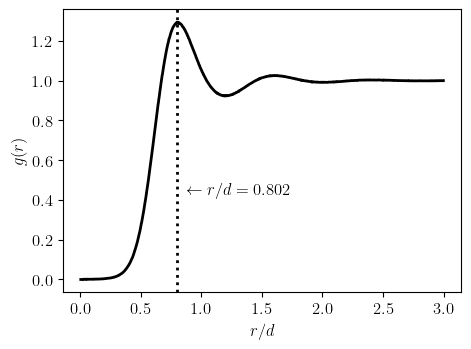

In [13]:
os.chdir(f"{root}/data/parametrization/water/nvt")

fname = f"nvt_A_{A_reduced:.3f}_Nm_{N_m}_rho_2.50"
if os.path.isfile(f"{fname}.rdf.npz"):
    npz = np.load(f"{fname}.rdf.npz")
    bins = npz["bins"] * ureg.angstrom
    rdf = npz["rdf"]
else:
    universe = mda.Universe(app.PDBxFile(f"{fname}.cif"), f"{fname}.nc")
    prdf = structure.ParallelRDF(
        universe.atoms,
        n_bins=n_bins,
        range=(0, (3 * scales["length"] / ureg.angstrom).magnitude)
    )
    prdf.run(start=500, n_jobs=10, module="joblib")
    prdf.save(f"{fname}.rdf")
    bins = prdf.results.bins * ureg.angstrom
    rdf = prdf.results.rdf
bins_reduced = bins / scales["length"]
i_peak = 1 + np.argmax(rdf[1:])
r_peak_reduced = bins_reduced[i_peak].magnitude

_, ax = plt.subplots()
ax.plot(bins_reduced[1:], rdf[1:], "k")
ylim = ax.get_ylim()
ax.plot((r_peak_reduced, r_peak_reduced), ylim, "k:")
ax.set_xlabel(r"$r / d$")
ax.set_ylabel(r"$g(r)$")
ax.set_ylim(ylim)
ax.text(7/8, (ylim[0] + np.min(rdf[i_peak:])) / 2,
        f"$\leftarrow r/d={r_peak_reduced:.3f}$")
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_rdf_Nm_{N_m}.eps"):
    plt.savefig(f"{root}/figures/water_rdf_Nm_{N_m}.eps", dpi=dpi)
plt.show()

#### Flory–Huggins parameter mapping

In [14]:
N = 50_000

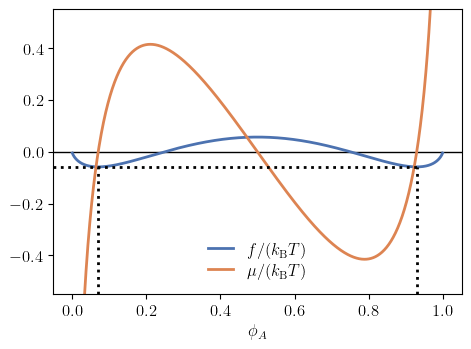

In [15]:
def flory_huggins_free_energy(phi_A, N_A, N_B, chi):
    phi_B = 1 - phi_A
    return phi_A * np.log(phi_A) / N_A + phi_B * np.log(1 - phi_A) / N_B + chi * phi_A * phi_B

def flory_huggins_free_energy_derivative(x, chi):
    return chi - np.log((1 - x) / x) / (1 - 2 * x)

chi = 3
phis_A = np.linspace(0, 1, 1001)
fs = flory_huggins_free_energy(phis_A, 1, 1, chi)
phis_A_spinodal = np.fromiter(
    (optimize.fsolve(flory_huggins_free_energy_derivative, x0, args=(chi,))
     for x0 in [0.1, 0.9]),
    count=2,
    dtype=float
)
f_spinodal = flory_huggins_free_energy(phis_A_spinodal[0], 1, 1, chi)

_, ax = plt.subplots()
ax.axhline(0, color="k", linewidth=1)
ax.plot(phis_A, fs, label="$f/(k_\mathrm{B}T)$", color=cmap[0])
ax.plot(phis_A, np.gradient(fs, phis_A, edge_order=2),
        label="$\mu/(k_\mathrm{B}T)$", color=cmap[1])
ax.plot((-0.05, phis_A_spinodal[1]), (f_spinodal, f_spinodal), "k:")
ax.plot((phis_A_spinodal[0], phis_A_spinodal[0]), (-0.55, f_spinodal), "k:")
ax.plot((phis_A_spinodal[1], phis_A_spinodal[1]), (-0.55, f_spinodal), "k:")
ax.legend()
ax.set_xlabel("$\phi_A$")
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.55, 0.55)
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_fh_energies_chi_3.eps"):
    plt.savefig(f"{root}/figures/water_fh_energies_chi_3.eps", dpi=dpi)
plt.show()

In [16]:
os.chdir(f"{root}/data/parametrization/flory_huggins")

dAs_over_A = np.unique(
    np.fromiter((f.replace(".xml", "").split("_")[8]
                 for f in glob.glob("*.xml")), dtype=float)
)
dAs_reduced = dAs_over_A * A_reduced
number_densities = np.empty((len(dAs_reduced), 2, 201)) / ureg.angstrom ** 3

for i, dA_over_A in enumerate(dAs_over_A):
    fname = f"nvt_N_{N}_Np_1_A_{A_reduced:.3f}_dA_{dA_over_A:.3f}"
    if os.path.isfile(f"{fname}.profile.npz"):
        npz = np.load(f"{fname}.profile.npz")
        bins = npz["bins"][0] * ureg.angstrom
        number_densities[i] = npz["number_densities"][0] / ureg.angstrom ** 3
    else:
        universe = mda.Universe(app.PDBxFile(f"{fname}.cif"), f"{fname}.nc")
        groups = [universe.select_atoms(f"resname {t}") for t in ["A", "B"]]
        center = universe.dimensions[:3].copy() / 2
        dp = profile.DensityProfile(groups, axes="z", recenter=(groups[0], center))
        dp.run(start=500)
        dp.save(f"{fname}.profile")
        bins = dp.results.bins[0] * ureg.angstrom
        number_densities[i] = dp.results.number_densities[0] / ureg.angstrom ** 3
bins_reduced = bins / scales["length"]
number_densities_reduced = (number_densities * scales["length"] ** 3).magnitude

chis = np.empty(dAs_reduced.shape)

for i, dA_over_A in enumerate(dAs_over_A):
    index_max_A = number_densities_reduced[i, 0].argmax()
    bool_equal = np.abs(np.gradient(number_densities_reduced[i, 0], edge_order=2)) < 5.55e-3
    indices_cutoff = np.where(np.diff(bool_equal))[0] + 1
    split_bool_equal = np.split(bool_equal, indices_cutoff)
    split_indices = np.split(np.arange(number_densities_reduced[i, 0].shape[0]), indices_cutoff)
    split_nd_md = np.split(number_densities_reduced[i, 0], indices_cutoff)
    indices = split_indices[
        np.fromiter([r.mean() if np.all(b) else 0 for r, b in zip(split_nd_md, split_bool_equal)],
                    dtype=float).argmax()
    ]
    phi_A = number_densities_reduced[i, 0][indices].mean() / number_densities_reduced[i, :, indices].sum(axis=1).mean()
    phi_A_round = np.round(phi_A, 6)
    chis[i] = np.log((1 - phi_A) / phi_A) / (1 - 2 * phi_A) if phi_A_round != 0.5 else 2

nvt_N_50000_Np_1_A_25.224_dA_0.050


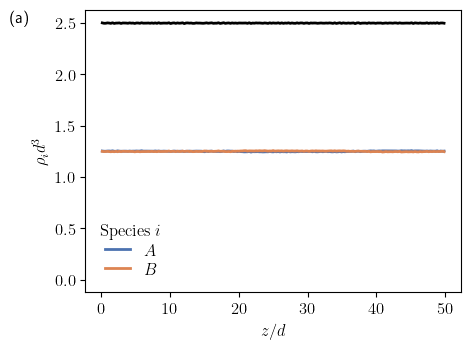

nvt_N_50000_Np_1_A_25.224_dA_0.075


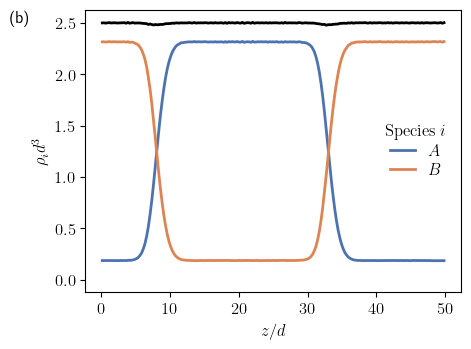

nvt_N_50000_Np_1_A_25.224_dA_0.100


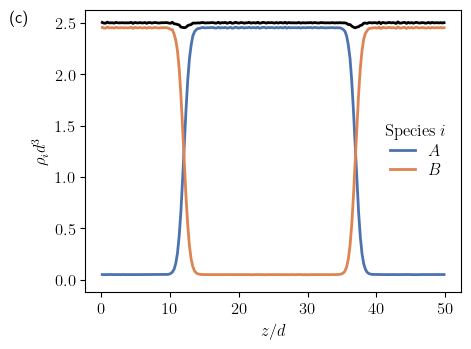

In [17]:
dAs_over_A_save = [0.05, 0.075, 0.1]

for i, (dA_over_A, nd_md) in enumerate(zip(dAs_over_A, number_densities_reduced)):
    if dA_over_A in dAs_over_A_save:
        fname = f"nvt_N_{N}_Np_1_A_{A_reduced:.3f}_dA_{dA_over_A:.3f}"
        print(fname)

        _, ax = plt.subplots()
        ax.plot(bins_reduced, nd_md[0], color=cmap[0], label="$A$")
        ax.plot(bins_reduced, nd_md[1], color=cmap[1], label="$B$")
        ax.plot(bins_reduced, nd_md.sum(axis=0), "k")
        ax.legend(title="$\mathrm{Species}\;i$")
        ax.set_xlabel("$z/d$")
        ax.set_ylabel(r"$\rho_i d^3$")
        ax.set_ylim((-0.125, 2.625))
        ax.text(-0.2, 0.959, f"({chr(97 + i)})", transform=ax.transAxes)
        if dA_over_A in dAs_over_A_save:
            if not os.path.isfile(f"{root}/figures/water_fh_number_density_dA_{dA_over_A:.3f}.eps"):
                plt.savefig(f"{root}/figures/water_fh_number_density_dA_{dA_over_A:.3f}.eps", dpi=dpi)
        plt.show()

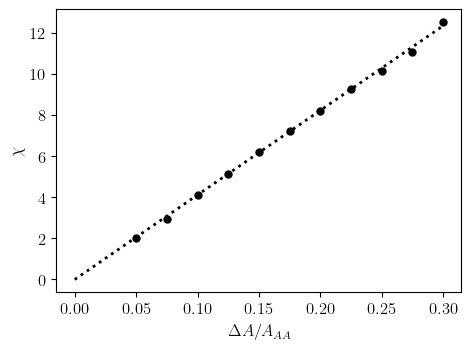

In [18]:
fit_fh = optimize.curve_fit(lambda x, p1: poly1(x, p1, 0), dAs_over_A[2:8], chis[2:8])[0]
dA_over_A_fit = np.linspace(0, dAs_over_A.max())

_, ax = plt.subplots()
ax.plot(dAs_over_A, chis, "ko", ms=5)
ax.plot(dA_over_A_fit, fit_fh * dA_over_A_fit, "k:")
ax.set_xlabel(r"$\Delta A / A_{AA}$")
ax.set_ylabel(r"$\chi$")
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/water_fh_mapping.eps"):
    plt.savefig(f"{root}/figures/water_fh_mapping.eps", dpi=dpi)
plt.show()

### Performance

In [19]:
# KAPPA_INV = 15.9835                 # Water dimensionless compressibility (300 K)
# OMEGA = 0.499                       # GCM scaling parameter

# mass = 18.01528 * ureg.gram / ureg.mole
# diameter = 0.275 * ureg.nanometer
# temp = 300 * ureg.kelvin
# N = 1_000
# rho_md = 2.5
# N_m = 4
# varepsilon_r = 78
# scales = get_lj_scale_factors({
#     "energy": (ureg.boltzmann_constant * temp).to(ureg.kilojoule),
#     "length": diameter * (N_m * rho_md) ** (1 / 3),
#     "mass": mass * N_m
# })

# rho = rho_md / scales["length"] ** 3
# box_length_nd = ((N / (2.5 * rho)) ** (1 / 3)).m_as(ureg.nanometer)
# volume = 2.5 * box_length_nd ** 3 * ureg.nanometer ** 3
# wall_positions, dimensions = create_atoms(
#     np.array((box_length_nd, box_length_nd, 0)),
#     lattice="hcp",
#     length=scales["length"].magnitude / 2,
#     flexible=True
# )
# dimensions *= ureg.nanometer
# dimensions[2] = volume / (dimensions[0] * dimensions[1])
# unit_cell_dimensions = scales["length"] * np.array((1, np.sqrt(3), 2 * np.sqrt(6) / 3)) / 2
# N_cells = dimensions / unit_cell_dimensions

# N_wall = wall_positions.shape[0] # single wall
# sigma_q = 0.005 * ureg.elementary_charge / ureg.angstrom ** 2
# q_wall = sigma_q * dimensions[0] * dimensions[1] / N_wall

# u_shift_md = 1e-3
# radius_nd = scales["length"].m_as(ureg.nanometer) / 2
# sigmas_i_sq = (np.array((radius_nd, 0, radius_nd)) * ureg.nanometer) ** 2
# sigmas_ij_sq = sigmas_i_sq + sigmas_i_sq[:, None]
# betas_ij = 3 / (2 * sigmas_ij_sq)
# alphas_ij_coefs = 1 + np.array((
#     (0, 0, -1),     # pp, pw, pi;
#     (0, -1, -1),    # wp, ww, wi;
#     (-1, -1, -1)    # ip, iw, ii
# ))
# A_md = (N_m * KAPPA_INV - 1) / (2 * OMEGA * rho_md)
# A = A_md * scales["molar_energy"] * scales["length"] ** 3
# alphas_ij = alphas_ij_coefs * A * (betas_ij / np.pi) ** (3 / 2)
# alphas_ij[np.isnan(alphas_ij)] = 0 * ureg.kilojoule / ureg.mole
# cutoff = optimize.fsolve(
#     lambda r: np.max(alphas_ij)
#               * np.exp(-np.min(betas_ij) * (r * ureg.nanometer) ** 2)
#               / scales["molar_energy"] - u_shift_md,
#     scales["length"].m_as(ureg.nanometer)
# )[0] * ureg.nanometer

# as_i_sq = (np.array((1, 0)) * scales["length"] / 2) ** 2
# as_ij = (as_i_sq + as_i_sq[:, None]) ** (1 / 2) # pp, pw; wp, ww
# alphas_e_ij = np.sqrt(np.pi / 2) / as_ij

### Polyelectrolyte–counterion–solvent supercapacitors

In [20]:
mass = 18.01528 * ureg.gram / ureg.mole
diameter = 0.275 * ureg.nanometer
temp = 300 * ureg.kelvin
rho_md = 2.5
N_m = 4
N_p = 60
varepsilon_r = 78
scales = get_lj_scale_factors({
    "energy": (ureg.boltzmann_constant * temp).to(ureg.kilojoule),
    "length": diameter * (N_m * rho_md) ** (1 / 3),
    "mass": mass * N_m
})

bcs = ["ic", "slab"]
dimensions = np.array((148.11739, 148.79716, 362.35028)) * ureg.angstrom
n_bins = 1_000_000
varepsilon = ureg.vacuum_permittivity * varepsilon_r
rho = rho_md / scales["length"] ** 3

#### Density and potential profiles

In [21]:
group_names = ("polyanions", "cations")
group_colors = ("#55aaff", "#ff557f")
xs_p = np.array((0.005, 0.025, 0.05, 0.1, 0.2))

In [22]:
bins = np.empty((len(bcs), len(xs_p), n_bins))
number_densities = np.zeros((len(bcs), len(xs_p), 2, n_bins))
charge_densities = np.zeros_like(bins)
potentials = np.zeros_like(bins)

for i, bc in enumerate(bcs):
    os.chdir(f"{root}/data/polyanion_counterion_solvent/edl/{bc}")
    for j, x_p in enumerate(xs_p):
        xml_files = glob.glob(f"*Np_{N_p}_xp_{x_p:.3f}*dV_0.000*.xml")
        n_trajs = len(xml_files)
        for xml_file in xml_files:
            fname = xml_file.rstrip(".xml")
            print(f"{bc}/{fname}")
            if os.path.isfile(f"{fname}.profile.npz"):
                npz = np.load(f"{fname}.profile.npz", allow_pickle=True)
                bins[i, j] = npz["bins"]
                number_densities[i, j] += npz["number_densities"][0]
                charge_densities[i, j] += npz["charge_densities"][0]
                potentials[i, j] += npz["potentials"].item()[0]
                print(f"Profiles loaded from '{fname}.profile.npz'.")
            else:
                universe = mda.Universe(app.PDBxFile(f"{fname}.cif"),
                                        f"{fname}.nc")
                if universe.trajectory.n_frames >= 2500:
                    groups = [universe.select_atoms(f"resname {r}")
                              for r in ("PAN", "CAT")]
                    dp = profile.DensityProfile(
                        groups,
                        axes="z",
                        n_bins=n_bins,
                        charges=(-1, 1),
                        scales=(1, 1, 1 / (2 + (bc == "slab")))
                    )
                    dp.run(start=500)
                    if bc == "ic":
                        dp.calculate_potential_profile(varepsilon_r, "z", dV=0)
                    else:
                        dp.calculate_potential_profile(varepsilon_r, "z", sigma_e=0)
                    dp.save(f"{fname}.profile")
                    bins[i, j] = dp.results.bins[0]
                    number_densities[i, j] += dp.results.number_densities[0]
                    charge_densities[i, j] += dp.results.charge_densities[0]
                    potentials[i, j] += dp.results.potentials[0]
                    print(f"Profiles computed and saved to '{fname}.profile.npz'.")
                else:
                    print("Simulation has not finished.")
        if n_trajs:
            number_densities[i, j] /= n_trajs
            charge_densities[i, j] /= n_trajs
            potentials[i, j] /= n_trajs
        else:
            number_densities[i, j] = charge_densities[i, j] = potentials[i, j] = np.nan

bins *= ureg.angstrom
number_densities *= ureg.angstrom ** -3
charge_densities *= ureg.elementary_charge / ureg.angstrom ** 3
potentials *= (scales["energy"] / ureg.elementary_charge).to(ureg.volt)

ic/nvt_N_96000_Np_60_xp_0.005_rp_78.0_A_25.224_dV_0.000__0
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.005_rp_78.0_A_25.224_dV_0.000__0.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.005_rp_78.0_A_25.224_dV_0.000__1
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.005_rp_78.0_A_25.224_dV_0.000__1.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.025_rp_78.0_A_25.224_dV_0.000__0
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.025_rp_78.0_A_25.224_dV_0.000__0.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.025_rp_78.0_A_25.224_dV_0.000__1
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.025_rp_78.0_A_25.224_dV_0.000__1.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.050_rp_78.0_A_25.224_dV_0.000__0
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.050_rp_78.0_A_25.224_dV_0.000__0.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.050_rp_78.0_A_25.224_dV_0.000__1
Profiles loaded from 'nvt_N_96000_Np_60_xp_0.050_rp_78.0_A_25.224_dV_0.000__1.profile.npz'.
ic/nvt_N_96000_Np_60_xp_0.100_rp_78.0_A_25.224_dV_0.000__0
Profiles loaded from 'nvt_N_96000_N

In [23]:
check = False
rebin_factor = 1_000
bins_rebinned_reduced = np.empty((len(bcs), len(xs_p), n_bins // rebin_factor))
number_densities_rebinned_scaled = np.empty((len(bcs), len(xs_p), 2, n_bins // rebin_factor))
charge_densities_rebinned_scaled = np.empty_like(bins_rebinned_reduced)

for i, bc in enumerate(bcs):
    for j, x_p in enumerate(xs_p):
        bins_rebinned_reduced[i, j] = rebin(bins[i, j], rebin_factor) / scales["length"]
        number_densities_rebinned_scaled[i, j] = rebin(number_densities[i, j], rebin_factor) / (x_p * rho)
        charge_densities_rebinned_scaled[i, j] = rebin(charge_densities[i, j], rebin_factor) / (x_p * rho)

        if check:
            print(f"{bc=}, {x_p=}")
            _, ax_rho = plt.subplots()
            for k, (ndrs, name, color) in enumerate(
                    zip(number_densities_rebinned_scaled[i, j], group_names, group_colors)
                ):
                ax_rho.plot(bins_rebinned_reduced[i, j], ndrs, alpha=0.75, color=color,
                            label=name)
            ax_rho.legend(title="species $i$", ncol=2)
            ax_rho.set_xlabel("$z / d$")
            ax_rho.set_ylabel(r"$\rho_i / \rho_i^\mathrm{bulk}$")
            ax_rho.text(-0.2, 0.959, " ", transform=ax_rho.transAxes)

            _, ax_psi = plt.subplots()
            ax_psi.plot(bins_rebinned_reduced[i, j],
                        rebin(potentials[i, j], rebin_factor), "k")
            ax_psi.set_xlabel("$z / d$")
            ax_psi.set_ylabel(r"$e \Psi / k_\mathrm{B} T$")
            ax_psi.text(-0.2, 0.959, " ", transform=ax_psi.transAxes)
            ax_psi.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

            plt.show()

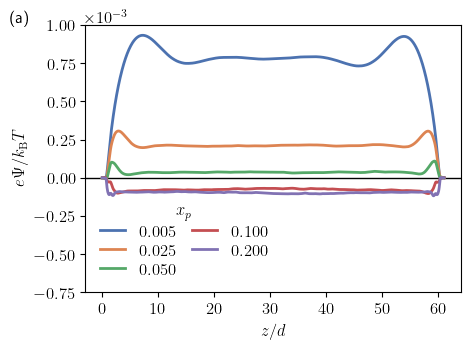

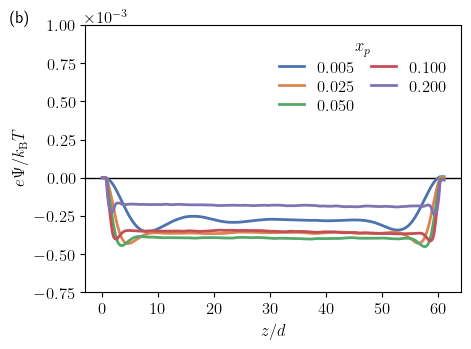

In [24]:
for i, bc in enumerate(bcs):
    _, ax = plt.subplots()
    ax.axhline(0, color="k", lw=1)
    for j, x_p in enumerate(xs_p):
        ax.plot(bins_rebinned_reduced[i, j], rebin(potentials[i, j], rebin_factor),
                label=f"${x_p:.3f}$", color=cmap[j])
    ax.legend(title="$x_p$", ncol=2)
    ax.set_xlabel("$z/d$")
    ax.set_ylabel(r"$e\Psi/k_\mathrm{B}T$")
    ax.set_ylim((-0.00075, 0.001))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.text(-0.2, 1.01, f"({chr(97 + i)})", transform=ax.transAxes)
    if not os.path.isfile(f"{root}/figures/pcs_{bc}_potential.eps"):
        plt.savefig(f"{root}/figures/pcs_{bc}_potential.eps", dpi=dpi)
plt.show()

ic


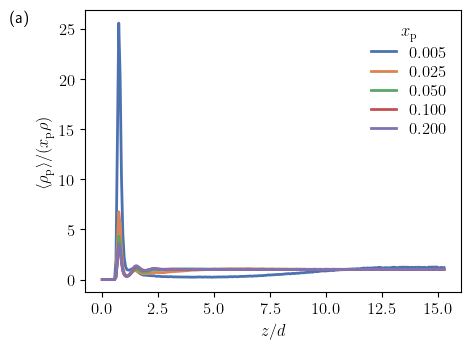

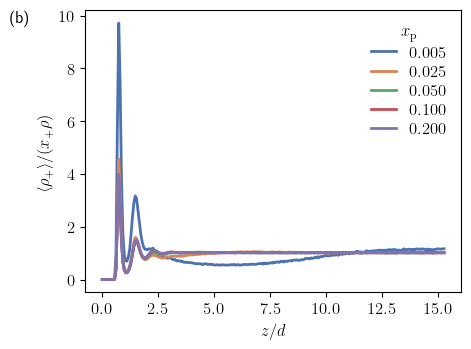

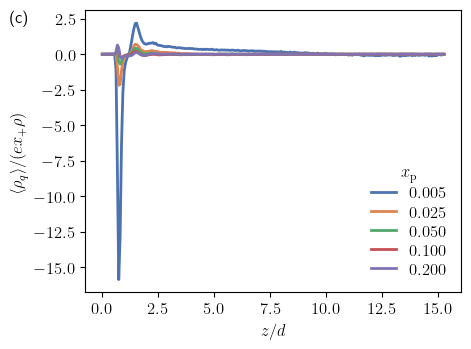

slab


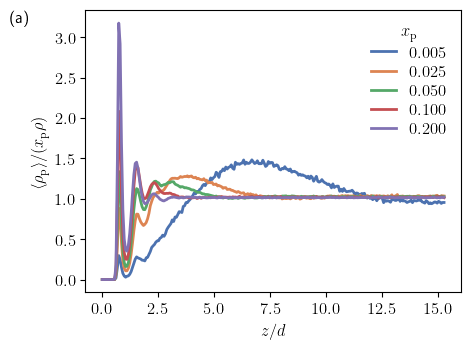

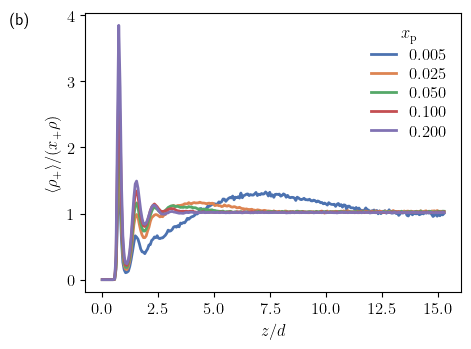

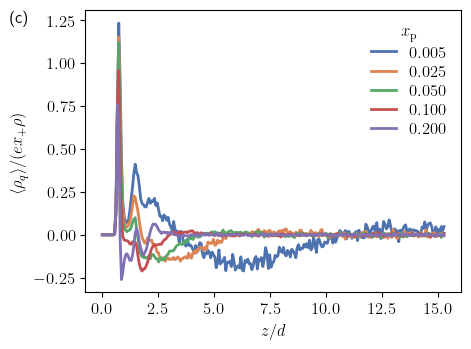

In [25]:
indices = np.where(bins_rebinned_reduced[0, 0] <= (dimensions[2] / (4 * scales["length"])))[0]
number_densities_peak_scaled = np.empty((2, len(xs_p), 2))

for i, bc in enumerate(bcs):
    print(bc)

    _, ax_pan = plt.subplots()
    _, ax_cat = plt.subplots()
    _, ax_charge = plt.subplots()

    for j, (x_p, x, y, z) in enumerate(
            zip(xs_p, bins_rebinned_reduced[i],
                number_densities_rebinned_scaled[i],
                charge_densities_rebinned_scaled[i])
        ):
        x_ = x[indices]
        y_ = (y[:, indices] + y[:, n_bins // rebin_factor - indices - 1]) / 2
        number_densities_peak_scaled[i, j, 0] = y_[0][argrelextrema(y_[0], np.greater)[0][0]]
        number_densities_peak_scaled[i, j, 1] = y_[1][argrelextrema(y_[1], np.greater)[0][0]]
        ax_pan.plot(x_, y_[0], color=cmap[j], label=f"${x_p:.3f}$")
        ax_cat.plot(x_, y_[1], color=cmap[j], label=f"${x_p:.3f}$")
        ax_charge.plot(
            x_,
            (z[indices] + z[n_bins // rebin_factor - indices - 1]) / 2,
            color=cmap[j],
            label=f"${x_p:.3f}$"
        )

    ax_pan.legend(title=r"$x_\mathrm{p}$")
    ax_pan.set_xlabel("$z/d$")
    ax_pan.set_ylabel(r"$\langle\rho_\mathrm{p}\rangle/(x_\mathrm{p}\rho)$")
    ax_pan.text(-0.2, 0.959, "(a)", transform=ax_pan.transAxes)
    plt.sca(ax_pan)
    if not os.path.isfile(f"{root}/figures/pcs_{bc}_rho_polyanion.eps"):
        plt.savefig(f"{root}/figures/pcs_{bc}_rho_polyanion.eps", dpi=dpi)

    ax_cat.legend(title=r"$x_\mathrm{p}$")
    ax_cat.set_xlabel("$z/d$")
    ax_cat.set_ylabel(r"$\langle\rho_+\rangle/(x_+\rho)$")
    ax_cat.text(-0.2, 0.959, "(b)", transform=ax_cat.transAxes)
    plt.sca(ax_cat)
    if not os.path.isfile(f"{root}/figures/pcs_{bc}_rho_counterion.eps"):
        plt.savefig(f"{root}/figures/pcs_{bc}_rho_counterion.eps", dpi=dpi)

    ax_charge.legend(title=r"$x_\mathrm{p}$")
    ax_charge.set_xlabel("$z/d$")
    ax_charge.set_ylabel(r"$\langle\rho_q\rangle/(ex_+\rho)$")
    ax_charge.text(-0.2, 0.959, "(c)", transform=ax_charge.transAxes)
    plt.sca(ax_charge)
    if not os.path.isfile(f"{root}/figures/pcs_{bc}_rho_charge.eps"):
        plt.savefig(f"{root}/figures/pcs_{bc}_rho_charge.eps", dpi=dpi)

    plt.show()

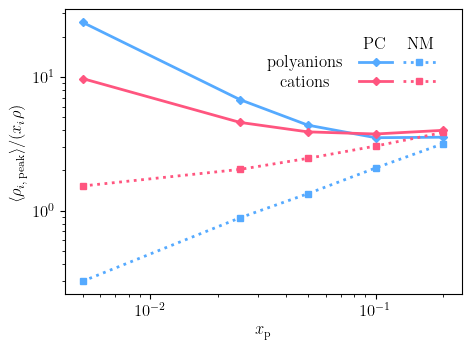

In [26]:
(props, nrow, start) = set_up_tabular_legend(
    [f"$\mathrm{{{g}}}$" for g in group_names],
    [r"$\mathrm{PC}$", r"$\mathrm{NM}$"],
    handletextpad=-1.75
)

fig, ax = plt.subplots()
for i, (ndps_bc, style) in enumerate(zip(number_densities_peak_scaled, ("D-", "s:"))):
    for j, (ndps, color) in enumerate(zip(ndps_bc.T, group_colors)):
        props["handles"][start + i * nrow + j], = ax.plot(xs_p, ndps, style, color=color, ms=5 + (i - 1))
lgd = ax.legend(**props, handlelength=2, borderaxespad=1.25)
fig.canvas.draw()
texts = lgd.get_texts()[:nrow]
bounds = [t.get_window_extent().bounds[2] / 2 for t in texts]
center = max(bounds)
for k, t in enumerate(texts):
    t.set_position((center - bounds[k], 0))
ax.set_xlabel("$x_\mathrm{p}$")
ax.set_xscale("log")
ax.set_ylabel("$\langle\\rho_{i,\,\mathrm{peak}}\\rangle/(x_i\\rho)$")
ax.set_yscale("log")
ax.text(-0.2, 0.959, " ", transform=ax.transAxes)
if not os.path.isfile(f"{root}/figures/pcs_rho_peaks.eps"):
    plt.savefig(f"{root}/figures/pcs_rho_peaks.eps", dpi=dpi)
plt.show()